# Agentic AI-101

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
# crete a .env file with the following content
# GROQ_API_KEY=your_groq_api_key
# LANGSMITH_API_KEY=your_langsmith_api_key
# LANGSMITH_PROJECT_ID=your_langsmith_project_name

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages



In [ ]:
# langsmith
# load_dotenv()
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
try:
    os.environ["LANGSMITH_API_KEY"] = os.environ['LANGSMITH_API_KEY']
    # Optional: Set a project name for organization
    os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")
    print("LangSmith environment variables set. Good to go!")
except Exception as e:
    print("LangSmith API Key not found. Tracing will be disabled.")

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003711119, 'queue_time': 0.049224201, 'total_time': 0.053711119}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-ca6f8bd2-f07e-428f-944f-4e8604be6097-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

### Prompt Chaining

**Prompt Chaining Workflow:**

-  Decomposes a task into a sequence of steps.
-  Each LLM call processes the output of the previous one.
-  Programmatic checks can be added at intermediate steps to ensure the process stays on track.

**When to Use This Workflow:**

- Ideal for tasks that can be cleanly decomposed into fixed subtasks.
- Trades off latency for higher accuracy by simplifying each LLM call into easier tasks.

![image.png](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/prompt_chain.png)


### Blog Generator with Prompt Chaining

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
    
## Title Assistant
system_message_title = SystemMessage(
    content=(
        "You are an intelligent blog title generator. Your task is to create catchy, engaging, "
        "and relevant single title based on the subject or text provided to you. Ensure that the titles "
        "are concise, informative, and tailored to attract readers' attention. Aim for creativity "
        "while maintaining clarity and relevance to the topic at hand."
    )
)
def title_assistant(state:MessagesState):
    return {"messages":[llm.invoke([system_message_title] + state["messages"])]}

## Blog Content Assistant
system_message_content = SystemMessage(
    content=(
        "You are a blog content generator. Your task is to create informative, engaging, and "
        "well-structured content based on the title provided to you. Ensure that the content is "
        "relevant, coherent, and tailored to the target audience. Aim for clarity, depth, and "
        "engagement while maintaining a high level of quality and accuracy."
    )
)
def content_assistant(state:MessagesState):
    return {"messages":[llm.invoke([system_message_content] + state["messages"])]}

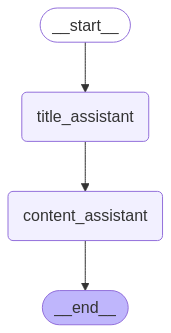

In [6]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

builder=StateGraph(MessagesState)

# Define the nodes
builder.add_node("title_assistant", title_assistant)
builder.add_node("content_assistant", content_assistant)

# Define the edges
builder.add_edge(START, "title_assistant")
builder.add_edge("title_assistant", "content_assistant")
builder.add_edge("content_assistant", END)


react_graph=builder.compile()


# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [7]:

messages = [HumanMessage(content="Generate a blog for AI Agents in healthcare")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Generate a blog for AI Agents in healthcare
================================== Ai Message ==================================

"Revolutionizing Healthcare: How AI Agents are Transforming Patient Care"
================================== Ai Message ==================================

### Revolutionizing Healthcare: How AI Agents are Transforming Patient Care

In the rapidly evolving landscape of healthcare, artificial intelligence (AI) is increasingly becoming a cornerstone of innovation and improvement. AI agents, in particular, are revolutionizing the way medical professionals diagnose, treat, and interact with patients. From enhancing clinical decision-making to improving patient care and accessibility, the impact of AI in healthcare is profound and promising. Let's explore how AI agents are transforming the healthcare industry.

#### What Are AI Agents in Healthcare?

AI agents in healthcare are software

## Parallelization¶

**Parallelization Workflow:**

- LLMs work simultaneously on tasks, with outputs aggregated programmatically.

- Two key variations:
    - Sectioning: Dividing a task into independent subtasks that run in parallel.
    - Voting: Running the same task multiple times to generate diverse outputs.

**When to Use Parallelization:**

- Effective for tasks that can be divided into subtasks and parallelized for speed.

- Useful when multiple perspectives or attempts are needed for higher confidence results.

- Ideal for complex tasks where separate considerations can be handled by individual LLM calls, allowing focused attention on specific aspects.

![image.png](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png)

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic: str
    title: str
    blog: str
    finalblog: str

In [12]:
# Define Nodes

def titleagent(state: State):
    """LLM call to generate title"""
    msg=llm.invoke(
        "<instruction>"
        f"You are an intelligent blog title generator. Your task is to create catchy, engaging,and relevant single title based on the {state['topic']} provided to you \n" + \
        "Ensure that the titles are concise, informative, and tailored to attract readers' attention. Aim for creativity while maintaining clarity and relevance to the topic at hand."
        "</instruction>"
        )
    return {"title": msg.content}

def blogagent(state: State):
    """LLM call to generate blog"""
    blog=llm.invoke(
        "<instruction>"
        f"You are an intelligent blog content generator. Your task is to create a blog content based on the {state['topic']} provided to you \n" + \
        "Ensure that the blog is informative, engaging, and tailored to attract readers' attention. Aim for clarity, depth, and engagement while maintaining a high level of quality and accuracy."
        "</instruction>"
        )
    return {"blog": blog.content}

def finalblogagent(state: State):
    """Combine the title and blog into a single output"""

    combined = f"Here's a title and blog about {state['topic']}!\n\n"
    combined += f"Title:\n{state['title']}\n\n"
    combined += f"Blog:\n{state['blog']}\n\n"
    return {"finalblog": combined}

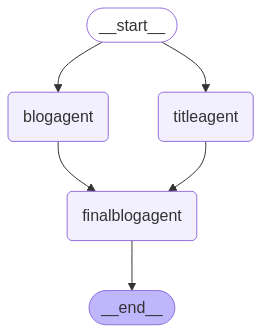

In [14]:
# Build workflow
parallel_builder = StateGraph(State)

# add nodes
parallel_builder.add_node("titleagent", titleagent)
parallel_builder.add_node("blogagent", blogagent)
parallel_builder.add_node("finalblogagent", finalblogagent)

# add edges
parallel_builder.add_edge(START, "titleagent")
parallel_builder.add_edge(START, "blogagent")
parallel_builder.add_edge("titleagent", "finalblogagent")
parallel_builder.add_edge("blogagent", "finalblogagent")
parallel_builder.add_edge("finalblogagent", END)

react_graph=parallel_builder.compile()


# Show workflow
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [15]:
# Invoke
state = react_graph.invoke({"topic": "Generate a blog for AI Agents in healthcare"})
print(state["finalblog"])

Here's a title and blog about Generate a blog for AI Agents in healthcare!

Title:
"Revolutionizing Healthcare: How AI Agents Are Transforming Patient Care"

Blog:
### The Future of Healthcare is Here: Exploring AI Agents in the Medical Field

In an era where technology continues to redefine the boundaries of what's possible, the healthcare industry stands on the cusp of a revolution catalyzed by artificial intelligence (AI). Among the myriad applications of AI in healthcare, AI agents are particularly noteworthy for their potential to transform the landscape of patient care, medical research, and service delivery. Let’s dive into the fascinating world of AI agents and explore their impact and potential in healthcare.

#### What Are AI Agents?

AI agents, in the context of healthcare, are software programs capable of performing tasks that would typically require human intelligence. These tasks can range from diagnosing diseases, managing patient data, monitoring patient health, to even

## Routing

**Workflow**

- Classifies input and directs it to a specialized follow-up task.

- Enables separation of concerns and the creation of more specialized prompts.

- Prevents performance degradation caused by optimizing for one type of input at the expense of others.

**When to Use Routing**

- Suitable for complex tasks with distinct categories that are better handled separately.

- Effective when classification can be performed accurately, either by an LLM or traditional classification models/algorithms.

- Ideal for scenarios requiring focused handling of specific aspects to improve overall performance.

![image.png](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/routing.png)

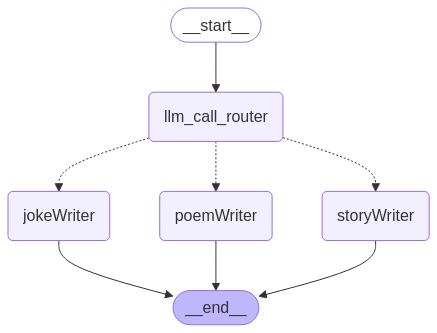

LLM call 2 is called
Why don't cats play poker in the wild? Because there are too many cheetahs!


In [16]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output for keeping relaibility of the output
# any output generated by the LLM will be validated against the Route model, ensuring it conforms to the specified structure (e.g., step must be one of "poem", "story", or "joke").
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def storyWriter(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def jokeWriter(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def poemWriter(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "storyWriter"
    elif state["decision"] == "joke":
        return "jokeWriter"
    elif state["decision"] == "poem":
        return "poemWriter"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("storyWriter", storyWriter)
router_builder.add_node("jokeWriter", jokeWriter)
router_builder.add_node("poemWriter", poemWriter)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "storyWriter": "storyWriter",
        "jokeWriter": "jokeWriter",
        "poemWriter": "poemWriter",
    },
)
router_builder.add_edge("storyWriter", END)
router_builder.add_edge("jokeWriter", END)
router_builder.add_edge("poemWriter", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## Orchestrator-Worker

**Workflow:**

-  Central LLM (orchestrator) dynamically breaks down tasks into subtasks.

-  Subtasks are delegated to worker LLMs for execution.

-  The orchestrator synthesizes the results from worker LLMs into a final output.

**When to Use this Workflow:**

- Ideal for complex tasks where subtasks cannot be predicted beforehand (e.g., coding tasks with dynamic file modifications).

- Offers flexibility by allowing the orchestrator to determine subtasks based on specific input.

- Differs from parallelization as subtasks are not pre-defined but dynamically created during execution.

![image.png](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png)

In [ ]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

#### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [ ]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


In [ ]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI in healthcare industry"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Agent with Tools, Memory, Conditional Edge and LangSmith Tracing

In [ ]:
# DuckDuckGo Search Tool
from langchain_community.tools import DuckDuckGoSearchRun
from IPython.display import Markdown

tool = DuckDuckGoSearchRun(num_results=3)
Markdown(tool.invoke("What's a 'node' in LangGraph?"))


In [ ]:
# memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
from typing import Annotated
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tools = [tool]
llm=ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add nodes
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
# Setting thread for the conversation
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
user_input = "What is the weather like in Bangalore, India?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

### Agent with Multiple Tools

In [ ]:
import os
import operator
from typing import TypedDict, Annotated, Sequence, List, Tuple, Union
from dotenv import load_dotenv

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# --- 1. Load Environment Variables ---
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment variables.")

# --- 2. Define Custom Tool ---
@tool
def multiply(a: float, b: float) -> float:
    """
    Multiplies two numbers (a and b) and returns the result.
    Use this tool when you need to calculate the product of two specific numbers.
    Args:
        a: The first number.
        b: The second number.
    """
    print(f"\n--- Calling Multiply Tool with a={a}, b={b} ---")
    result = a * b
    print(f"--- Multiply Tool Result: {result} ---")
    return result

# --- 3. Define Standard Tools ---
ddg_search = DuckDuckGoSearchRun()

# List of available tools (decorated function and DuckDuckGo instance work directly)
tools = [multiply, ddg_search]

# --- 4. Set up the LLM ---
llm=ChatGroq(model="qwen-2.5-32b")

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# --- 5. Define Agent State ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# --- 6. Define Graph Nodes ---

# Node to call the LLM (remains the same)
def call_model(state: AgentState):
    """Invokes the LLM with the current state messages."""
    print("\n--- Calling Model ---")
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    print(f"--- Model Response: {response.content} ---")
    # Check if the response contains tool calls and print them for debugging
    if isinstance(response, AIMessage) and response.tool_calls:
         print(f"--- Model generated tool calls: {response.tool_calls} ---")
    return {"messages": [response]}


tool_node = ToolNode(tools)

# --- 7. Define Conditional Edge Logic ---
def should_continue(state: AgentState) -> str:
    """Decides the next step based on the last message."""
    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("--- Decision: Continue (Tool Call) ---")
        return "continue"
    else:
        print("--- Decision: End ---")
        return "end"

# --- 8. Build the Graph ---
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", call_model)
# Add the ToolNode directly <<< CHANGED HERE
workflow.add_node("action", tool_node)

# Set the entry point
workflow.set_entry_point("agent")

# Add conditional edges (remains the same)
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)

# Add edge from action back to agent (remains the same)
workflow.add_edge("action", "agent")

# Compile the graph into a runnable app
app = workflow.compile()

# --- 9. Run the Agent ---
def run_agent(query: str):
    """Runs the agent graph with the user query."""
    print(f"\n--- Running Agent with Query: '{query}' ---")
    inputs = {"messages": [HumanMessage(content=query)]}
    # Stream events for better visibility during execution (optional but helpful)
    print("--- Streaming Events ---")
    for event in app.stream(inputs):
        for key, value in event.items():
            if key == 'agent':
                print(f"Node 'agent' output: {value}")
            elif key == 'action':
                 print(f"Node 'action' output: {value}")
        print("---")


# Example Usage
print("\n" + "="*30 + " Example 1: Multiplication " + "="*30)
run_agent("What is 123 times 456?")

print("\n" + "="*30 + " Example 2: Search " + "="*30)
run_agent("What is the latest news about LangGraph?")

print("\n" + "="*30 + " Example 3: Combined " + "="*30)
run_agent("Search for the population of London, UK, then multiply it by 3.")

print("\n" + "="*30 + " Example 4: No Tool Needed " + "="*30)
run_agent("Hello, how are you today?")